# Monet Art Generation using Generative Adversarial Networks
### University of Colorado Boulder
DTSA 5511

Deep Learning

Spring 2024

Anna Sanders

Oscar-Claude Monet, or often referred to as just Monet, is one of the most famous imporessionist painters. His paintings can be described, from somone who has almost no knowledge of art or art critiques, as realistic, but slightly abstract in the sense that the brush strokes in the paintings are still visible; Monet's paintings are also very colorful, but not bold (per se). One of Monet's most famous series of paintings are from his Water Lilies study, which depict water lilies and various scenery from his flower garden in Giverny, France.

Monet has been (dead) for almost 100 years, but yet his paintings still inspire people around the world. While no one alive can create a new Monet painting, both people and technology can attempt to immitate Monet's style. Generative Adversarial Networks, or GANs, can be used to train deep learning networks by comparing generated images against actual Monet paintings and retraining the network.

In [1]:
import numpy as np
import pandas as pd
import re
import string
from os import listdir

# Plotting Images
import matplotlib.pyplot as plt

# Image Processing
from PIL import Image

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

AUTOTUNE = tf.data.AUTOTUNE

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Data Exploration

The images in this dataset are provided in both .jpg and .tfrec format. We must first load the data and transform the images into vectors before training the model.

In [2]:
path_monet_jpg = '/kaggle/input/gan-getting-started/monet_jpg/'
path_photo_jpg = '/kaggle/input/gan-getting-started/photo_jpg/'

images_monet_jpg = [f for f in listdir(path_monet_jpg)]
images_photo_jpg = [f for f in listdir(path_photo_jpg)]

print('Monet Images:', len(images_monet_jpg))
print('Phot Images:', len(images_photo_jpg))

Monet Images: 300
Phot Images: 7038


In this datset, there are 300 Monet paintings and 7,038 photo images. Since the minimum submission size is 7,000, we can focus on training the model and producting one Monet-like image for every photo. We can take a look at some of these paintings and images.

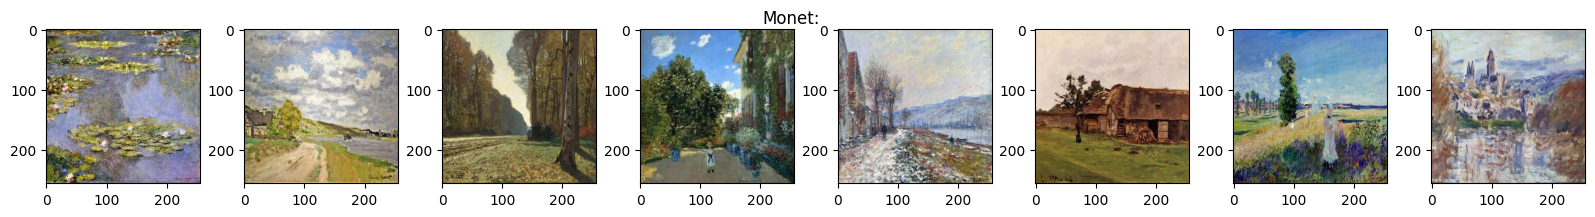

In [3]:
n = 8
fig, ax = plt.subplots(1,n,figsize=(20,2))
df = images_monet_jpg
for i in range(n):
    im = Image.open(path_monet_jpg+df[i])
    ax[i].imshow(im)
fig.suptitle('Monet:')
plt.show()

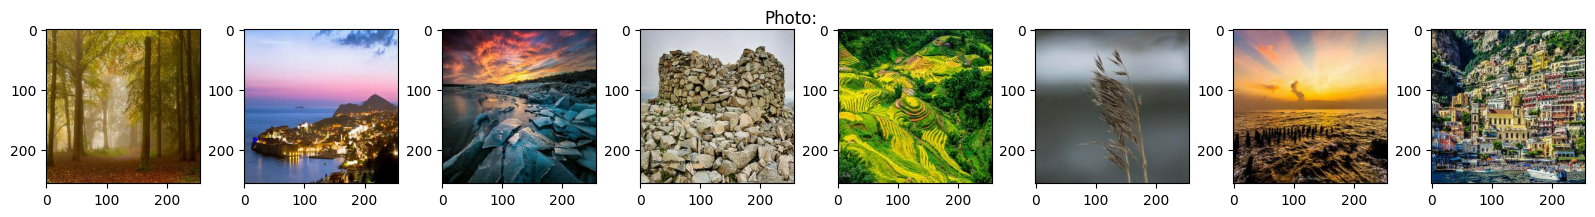

In [4]:
n = 8
fig, ax = plt.subplots(1,n,figsize=(20,2))
df = images_photo_jpg
for i in range(n):
    im = Image.open(path_photo_jpg+df[i])
    ax[i].imshow(im)
fig.suptitle('Photo:')
plt.show()

We can see that the Monet paintings are a selection of some paintings. Even at a low resolution, we can still make out the brush strokes and the impressionist style of the paintings. The photos, on the other hand, are very vibrant and comparatively look to be a higher resolution.

In [5]:
im = Image.open(path_monet_jpg+images_monet_jpg[1])
print('Monet Image Size:', im.format, im.size, im.mode)

im = Image.open(path_photo_jpg+images_photo_jpg[1])
print('Photo Image Size:',im.format, im.size, im.mode)

Monet Image Size: JPEG (256, 256) RGB
Photo Image Size: JPEG (256, 256) RGB


Both the Monet and Photo images are 256 x 256 pixels and are in RGB.

At this point, we do not need to 'clean' any of the images. However, during the model training process, we should utilize some CNN archiecture to standardize the images.

## Building the Model

A GAN has two main parts: 
1. Generator: The generator 'generates' an image to compare a real or target image (in this case, as Monet Painting) against
2. Discriminator: The descriminator compares the 'real' image to the 'generated' image and produces a cost to be used as inputs in the generator to re-train the model

In addition to the generator and discriminator, we also should normalize the images before being fed into the model.

We will need to build functions for both and create an overall process to link the two functions.

There are a wide variety of CycleGAN tutorials out there, including the one [linked](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) in the overview of this project. I will be using the [tensorflow tutorial](https://www.tensorflow.org/tutorials/generative/cyclegan), which also uses [this tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix).

We will be loading in images using the method found in [this](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) tutorial.

In [6]:
GCS_PATH = '/kaggle/input/gan-getting-started'

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256,256, 3])
    return image

def random_flip(image):
    image = tf.image.random_flip_left_right(image)
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def read_tfrecord_flip(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    image = random_flip(image)
    return image


def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def load_dataset_flip(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord_flip, num_parallel_calls=AUTOTUNE)
    return dataset



monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset_flip(PHOTO_FILENAMES, labeled=True).batch(1)

Monet TFRecord Files: 5
Photo TFRecord Files: 20


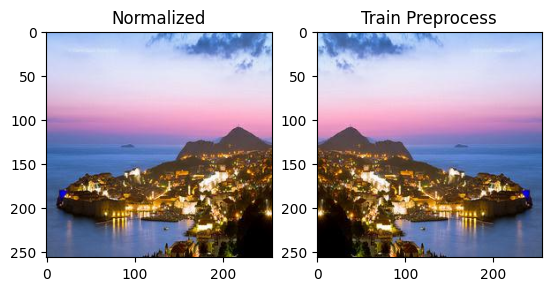

In [7]:
tf.random.set_seed(12)
im = Image.open(path_photo_jpg+images_photo_jpg[1])
im = tf.cast(im, tf.float32)
im = (im / 127.5) - 1
p_im = random_flip(im)

plt.subplot(121)
plt.title('Normalized')
plt.imshow(im * 0.5 +0.5)

plt.subplot(122)
plt.title('Train Preprocess')
plt.imshow(p_im * 0.5 +0.5)

We can see that the train preprocess flipped the original normalized image. We can now load and preprocess our images.

In [36]:
# dimensions wrong
# monet_ds = tf.keras.utils.image_dataset_from_directory(
#     path_monet_jpg,
#     seed=101,
#     image_size=(256, 256),
#     labels=None
# )

# photo_ds = tf.keras.utils.image_dataset_from_directory(
#     path_photo_jpg,
#     seed=101,
#     image_size=(256, 256),
#     labels=None
# )

Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


In [37]:
# monet_ds = monet_ds.cache().map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(1)

# photo_ds = photo_ds.cache().map(preprocess_image_flip, num_parallel_calls=AUTOTUNE).batch(1)

We are not flipping the Monet images, as it is possible that the left and right side of Monet's paintings are unqiue enough where flipping the painting will produce less 'Monet like' results.

The downsample and upsample convert the real images into inputs and the outputs back into images. Both the downsample and upsample are combined in a generator function. Lastly, the discriminator function is used to compare the real images to the generated images.

In [8]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
    
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())
    
    return result

OUTPUT_CHANNELS = 3

def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)
    
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 3])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

We now combine these functions, as well as define loss functions, to create the overall GAN. Parts of this code were adapted from [this tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook).

In [9]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [10]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_g,
        generator_f,
        discriminator_y,
        discriminator_x,
        lambda_cycle=5,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = generator_g
        self.p_gen = generator_f
        self.m_disc = discriminator_y
        self.p_disc = discriminator_x
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [11]:
with strategy.scope():
    generator_g = Generator()
    generator_f = Generator()

    discriminator_y = Discriminator()
    discriminator_x = Discriminator()

In [12]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = loss_obj(tf.ones_like(real), real)

        generated_loss = loss_obj(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

    def generator_loss(generated):
        return loss_obj(tf.ones_like(generated), generated)

    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [13]:
with strategy.scope():
    generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [14]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        generator_g, generator_f, discriminator_y, discriminator_x
    )

    cycle_gan_model.compile(
        m_gen_optimizer = generator_g_optimizer,
        p_gen_optimizer = generator_f_optimizer,
        m_disc_optimizer = discriminator_y_optimizer,
        p_disc_optimizer = discriminator_x_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [79]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds.take(100), photo_ds.take(250))),
    epochs=25
)

Epoch 1/25
100/100 [==============================] - 570s 5s/step - monet_gen_loss: 4.2642 - photo_gen_loss: 4.2518 - monet_disc_loss: 0.7626 - photo_disc_loss: 0.7444
Epoch 2/25
100/100 [==============================] - 516s 5s/step - monet_gen_loss: 2.8252 - photo_gen_loss: 2.8257 - monet_disc_loss: 0.6889 - photo_disc_loss: 0.6925
Epoch 3/25
100/100 [==============================] - 522s 5s/step - monet_gen_loss: 2.6198 - photo_gen_loss: 2.6111 - monet_disc_loss: 0.6762 - photo_disc_loss: 0.6811
Epoch 4/25
100/100 [==============================] - 528s 5s/step - monet_gen_loss: 2.4663 - photo_gen_loss: 2.4629 - monet_disc_loss: 0.6718 - photo_disc_loss: 0.6763
Epoch 5/25
100/100 [==============================] - 530s 5s/step - monet_gen_loss: 2.3409 - photo_gen_loss: 2.3371 - monet_disc_loss: 0.6685 - photo_disc_loss: 0.6720
Epoch 6/25
100/100 [==============================] - 536s 5s/step - monet_gen_loss: 2.2946 - photo_gen_loss: 2.2911 - monet_disc_loss: 0.6663 - photo_disc

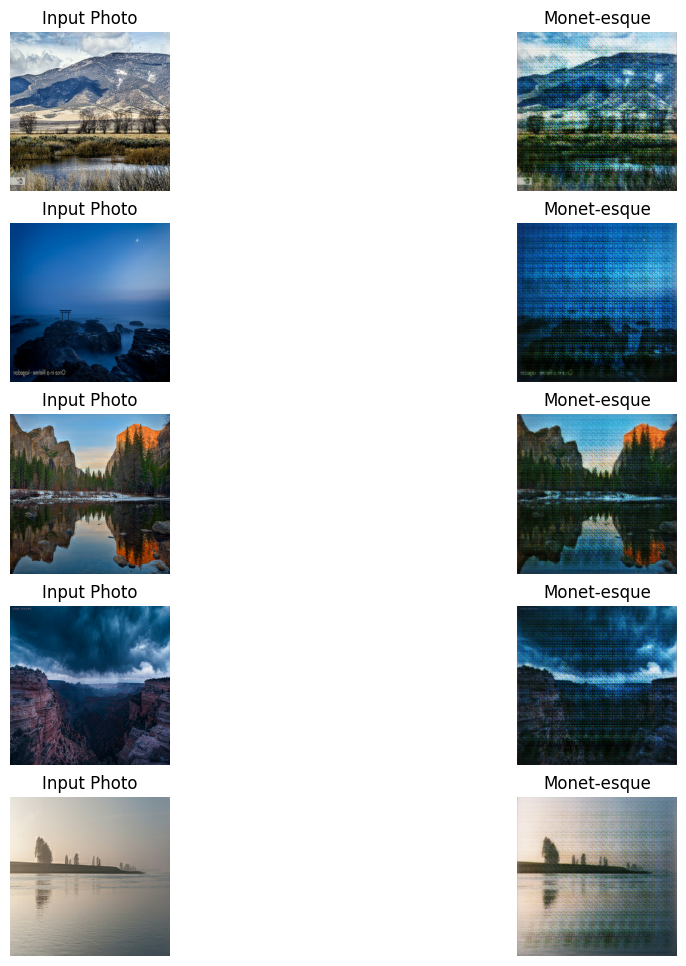

In [80]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = generator_f(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [84]:
import PIL
! mkdir ../images

i = 1
for img in photo_ds:
    prediction = generator_f(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1
    print(i)


import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

mkdir: cannot create directory ‘../images’: File exists


'/kaggle/working/images.zip'

# Conclusion

Unfortunatly, this project was not very sucessfull. The overall score was 114.785, which is very high considering the current lowest score is around 35. 

![](monet-art-generation-gans_screenshot.png)

The largest improvement this model could have is to include more data. While I do not know the exact time it takes to run, the model fitting itself takes at least 3 hours using the kaggle compute resources. Adding more images would likely increase this time. I do think the results would be better, as the model itself it a wall around 20 epochs with no improvements to the loss function. Additionally, hyperparameters and the various up and downsample functions could be modified to improve the model. However, as this is just a weekly project, these results, while not signficant, are still relevant.

Comparing the two tutorials used, I think the one provided in the competition overview was the most helpful. Functionally, they both had the same up and downsample functions, generator function, and loss functions, but when running the competition one, the epoch results and loss were clearly displayed, while the tf tutorial only printed out a sample image after training was complete.

# Second Model Attempt

Due to processing time, this model was trained post submission. We can attempt to investigate the effect of training a model with a larger number of photos, but a smaller number of epochs.

In [15]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds.take(500), photo_ds.take(1000))),
    epochs=5
)

Epoch 1/5
300/300 [==============================] - 1142s 4s/step - monet_gen_loss: 3.0893 - photo_gen_loss: 3.0852 - monet_disc_loss: 0.7056 - photo_disc_loss: 0.7060
Epoch 2/5
300/300 [==============================] - 1119s 4s/step - monet_gen_loss: 2.2698 - photo_gen_loss: 2.2421 - monet_disc_loss: 0.6711 - photo_disc_loss: 0.6791
Epoch 3/5
300/300 [==============================] - 1107s 4s/step - monet_gen_loss: 2.1614 - photo_gen_loss: 2.1545 - monet_disc_loss: 0.6696 - photo_disc_loss: 0.6749
Epoch 4/5
300/300 [==============================] - 1101s 4s/step - monet_gen_loss: 2.1098 - photo_gen_loss: 2.1016 - monet_disc_loss: 0.6676 - photo_disc_loss: 0.6713
Epoch 5/5
300/300 [==============================] - 1112s 4s/step - monet_gen_loss: 2.0508 - photo_gen_loss: 2.0520 - monet_disc_loss: 0.6646 - photo_disc_loss: 0.6691


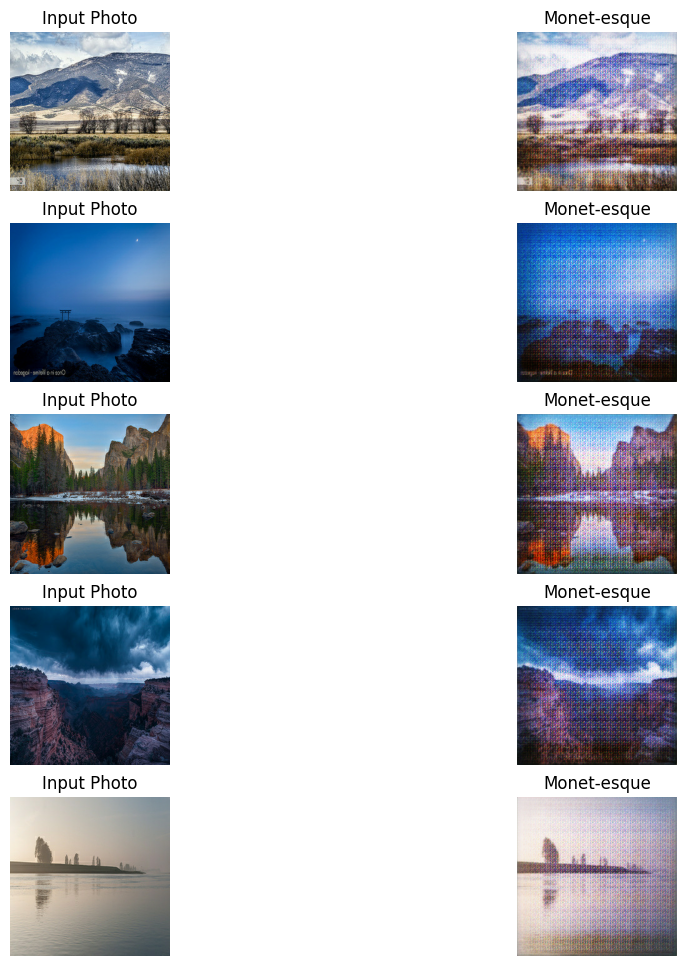

In [16]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = generator_f(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Second Model Reflection
Just looking at the losses, this model did worse than the first overall, but achieved the same result on epoch 5 as the previous model's epoch 18. The first model roughly completed one epoch every 530 seconds, for a rough total of 13,250 seconds. The second model completed one epoch roughly every 1,120 seconds for a total time of 5,600. Compared to an 18 epoch run of the first model (~9,540 seconds), the second model runs faster.

# Resources
- https://en.wikipedia.org/wiki/Claude_Monet
- https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
- https://blog.keras.io/building-autoencoders-in-keras.html
- https://jonathan-hui.medium.com/gan-cyclegan-6a50e7600d7
- https://jonathan-hui.medium.com/gan-a-comprehensive-review-into-the-gangsters-of-gans-part-1-95ff52455672
- https://jonathan-hui.medium.com/gan-a-comprehensive-review-into-the-gangsters-of-gans-part-2-73233a670d19
- https://en.wikipedia.org/wiki/Generative_adversarial_network
- https://www.tensorflow.org/tutorials/generative/cyclegan
- https://www.tensorflow.org/tutorials/load_data/tfrecord
- https://www.tensorflow.org/tutorials/generative/pix2pix
- https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py